### <center>$\text{Do Fundamentals Matter?}$
### <center>$\text{Comparing Univariate versus Multivariate LSTM Neural Networks for Ethereum Price Prediction}$
<center>$\text{CS156 Fall 2020 (Shekhar)}$
<center>$\text{Rebecca Mqamelo}$

# Import libraries

In [1]:
# For parsing the data
import urllib3
from urllib.request import urlopen
from urllib.request import Request
import certifi # for http: certificate verification when parsing urls
from bs4 import BeautifulSoup

import numpy as np
from numpy import concatenate
import scipy.stats
from scipy.stats import spearmanr
import pandas as pd
import time
import datetime
from datetime import datetime, timedelta
import gc
import requests

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

# The tensorflow GPU doesn't support macOS versions of 12.0 and higher
# The two lines below prevent the kernel from dying when running model predictions
# Credit to https://www.kaggle.com/product-feedback/41221 for the easy fix
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.layers import LSTM, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.layers.recurrent import LSTM
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

In [2]:
# Set up for plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
#matplotlibastyle.use('ggplot')
rcParams['figure.figsize'] = 20,10
matplotlib.style.use('tableau-colorblind10')
%matplotlib inline

blue, orange, red = '#1f77b4', '#ff7f0e', '#d62728'

In [3]:
neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128     
epochs = 53                  
window_len = 7                # integer to be used as the look-back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training

# Preprocessing, plotting and model functions

In [4]:
def normalize(data):    
    """
    This function uses a MinMaxScalar to scale features between a range of 0 and 1
    """
    values = data.values
    values = values.astype('float32')
    #scaler = StandardScaler()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values) # note: scaler converts df into numpy array
    return pd.DataFrame(scaled, columns=data.columns, index=data.index)

    
def split_data(data, training_size=0.8):
    """
    This function splits the data into a training_set and test_set
    """
    return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, multidimensional):
    """
    This function creates an input array X which contains historical data for the size of the window len.
    The returned array is in the 3-D format for a LSTM model [samples, timesteps, features]
    """
    
    if multidimensional == False:
        # Filter out only the price data
        data = data['price']
        inputs = []
        for i in range(len(data) - window_len):
            temp_set = data[i:(i + window_len)].copy()
            inputs.append(temp_set)
            
        # Reshape input to be 3D [samples, timesteps, features]
        inputs = [np.array(inputs[i]) for i in range (len(inputs))]
        inputs = np.array(inputs)
        inputs  = inputs.reshape((inputs.shape[0], inputs.shape[1], 1))
    
        return inputs
        
    elif multidimensional == True:
        inputs = []
        for i in range(len(data) - window_len):
            temp_set = data[i:(i + window_len)].copy()
            inputs.append(temp_set)
        
        inputs = [np.array(inputs[i]) for i in range (len(inputs))]
        return np.array(inputs)
        
    
def create_outputs(data, multidimensional):
    """
    This function returns the normalized labels array ('Close') for the training and validation sets
    """
    return np.array(data['price'][window_len:])

In [5]:
def show_train_test(data, training_size):   
    """
    Returns a normalized price plot which highlights where the test data lies in relation to the train set 
    """
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 100
    
    # visualise train/test samples
    data_size = data.shape[0]
    train_size = int(data_size * training_size)
    test_size = data_size - train_size

    plt.figure(figsize=(20,10))

    plt.plot(np.arange(train_size+test_size), data['price'], color='grey', label='True Signal ETH') 
    plt.plot(np.arange(train_size, train_size+test_size), data['price'].iloc[train_size:], color=blue, label='Test Signal ETH')

    plt.axvspan(train_size, test_size+train_size, facecolor=blue, alpha=0.1)
    plt.xlabel("Data Points")
    plt.ylabel("Time-Series")
    plt.legend(loc=2)

In [6]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    
    This function builds a 3-layered RNN model with LSTM cells and dropouts after each LSTM layer. 
    Finally, a dense layer produces the output using keras' sequential model.
    """
    
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    
    return model

In [7]:
def date_labels(train_or_test):
    dates = train_or_test.index[:-window_len].values
    extracted_dates = [datetime.utcfromtimestamp(i.astype('O')/1e9) for i in dates]
    return [d.strftime('%m/%d/%Y') for d in extracted_dates]

def plot_results(data, history, model, multidimensional=False):
    """
    This function unscales the price predictions and plots them against actual USD price.
    """

    yorg_test = test_set_raw['price'][window_len:].values.tolist()
    yhat_train = (np.transpose(model.predict(X_train)) + 1) * train_set_raw['price'].values[:-window_len]
    
    yorg_train = train_set_raw['price'][window_len:].values.tolist()
    yhat_test = (np.transpose(model.predict(X_test)) + 1) * test_set_raw['price'].values[:-window_len]
    rmse = np.sqrt(mean_squared_error(yhat_test[0], yorg_test))
    
    plt.figure(figsize=(25, 20))
    plt.subplot(311)
    plt.plot(history.epoch, history.history['loss'], )
    plt.plot(history.epoch, history.history['val_loss'])
    plt.xlabel('Number of Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(['Training', 'Test'])
    if multidimensional == False:
        plt.title('Model Loss (Univariate LSTM)', fontsize=20)
    elif multidimensional == True:
        plt.title('Model Loss (Multivariate LSTM)', fontsize=20)

    ax1 = plt.subplot(312)
    plt.plot(yorg_train)
    plt.plot(yhat_train[0])
    
    if multidimensional == False:
        plt.title('Single Point Price Prediction on Training Set (Univariate LSTM)', fontsize=20)
    elif multidimensional == True:
        plt.title('Single Point Price Prediction on Training Set (Multivariate LSTM)', fontsize=20)
    
    #date_list = date_labels(train_set)
    plt.xlabel('Dates', fontsize=15)
    plt.ylabel('Price', fontsize=15)
    plt.legend(['Actual','Predicted'])

    
    ax2 = plt.subplot(313)
    if multidimensional == False:
        plt.title('Single Point Price Prediction on Test Set (Univariate LSTM | MSE %.5f)' % rmse, fontsize=20)
        plt.plot(yorg_test)
        plt.plot(yhat_test[0])

    elif multidimensional == True:
        plt.title('Single Point Price Prediction on Test Set (Multivariate LSTM | MSE %.5f)' % rmse, fontsize=20)
        plt.plot(yorg_test)
        plt.plot(yhat_test[0])
        
    plt.xlabel('Dates', fontsize=15)
    plt.ylabel('Price', fontsize=15)        
    plt.legend(['Actual','Predicted'])

    date_list = date_labels(test_set)
    ax2.set_xticks([x for x in range(len(date_list))])
    for label in ax2.set_xticklabels([date for date in date_list], rotation=40)[::2]:
        label.set_visible(False)

    plt.show()

# Univariate LSTM

Predicting the future price of Ethereum based on historical prices only

In [8]:
# First load all the data to calculate techincal indicators, then cut later (avoids nans for TIs like SMA)
eth_data = pd.read_csv('/Users/rebeccamqamelo/Desktop/CS156/Final Project/eth_data.csv')
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data.set_index('Date', inplace=True)
eth_data.rename({'Close': 'price'}, axis=1, inplace=True)
eth_data.drop('Adj Close', axis=1, inplace=True)
print('N. rows ETH:', len(eth_data))
print('Start:', eth_data.index.min(), 'End:', eth_data.index.max())
eth_data.head()

N. rows ETH: 1960
Start: 2015-08-07 00:00:00 End: 2020-12-17 00:00:00


,Open,High,Low,price,Volume
Date,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,164329
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100


In [9]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=20).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.ewm(dataset['price'], span=26, adjust=False)
    #dataset['12ema'] = pd.ewm(dataset['price'], span=12, adjust=False)
    dataset['26ema'] = dataset['price'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['price'].ewm(span=12, adjust=False).mean()
    #dataset['MACD'] = (dataset['12ema']-dataset['26ema']) ⚠️ omitted, low correlation

    # Create Bollinger Bands
    std = dataset['price'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21'] + (std*2)
    dataset['lower_band'] = dataset['ma21'] - (std*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    return dataset

def plot_technical_indicators(dataset):
    
    plt.figure(figsize=(16, 10), dpi=100)
    plt.plot(dataset['ma7'], label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'], label='Closing Price', color='b')
    plt.plot(dataset['ma21'], label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(dataset.index, dataset['lower_band'], dataset['upper_band'], color='#ADCCFF', alpha='0.35')
    plt.title('Technical indicators for Ethereum')
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.legend()
    plt.show()

In [10]:
eth_data = get_technical_indicators(eth_data)

# Isolate 2020 data
eth_data = eth_data[(eth_data.index > '2019-12-31') & (eth_data.index < '2020-12-17')]
eth_data.head()

,Open,High,Low,price,Volume,ma7,ma21,26ema,12ema,upper_band,lower_band,ema
Date,,,,,,,,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,7935230330,129.957551,131.648260,135.920287,130.983347,144.682420,118.614100,130.734767
2020-01-02,130.820038,130.820038,126.954910,127.410179,8032709256,130.107402,130.771532,135.289909,130.433629,142.442559,119.100505,128.518375
2020-01-03,127.411263,134.554016,126.490021,134.171707,10476845358,131.101274,130.336656,135.207079,131.008718,140.344259,120.329052,132.287263
2020-01-04,134.168518,136.052719,133.040558,135.069366,7430904515,132.065082,129.934375,135.196878,131.633433,138.565787,121.302962,134.141998
2020-01-05,135.072098,139.410202,135.045624,136.276779,7526675353,132.282053,130.067512,135.276871,132.347794,137.072670,123.062355,135.565185


/Users/rebeccamqamelo/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


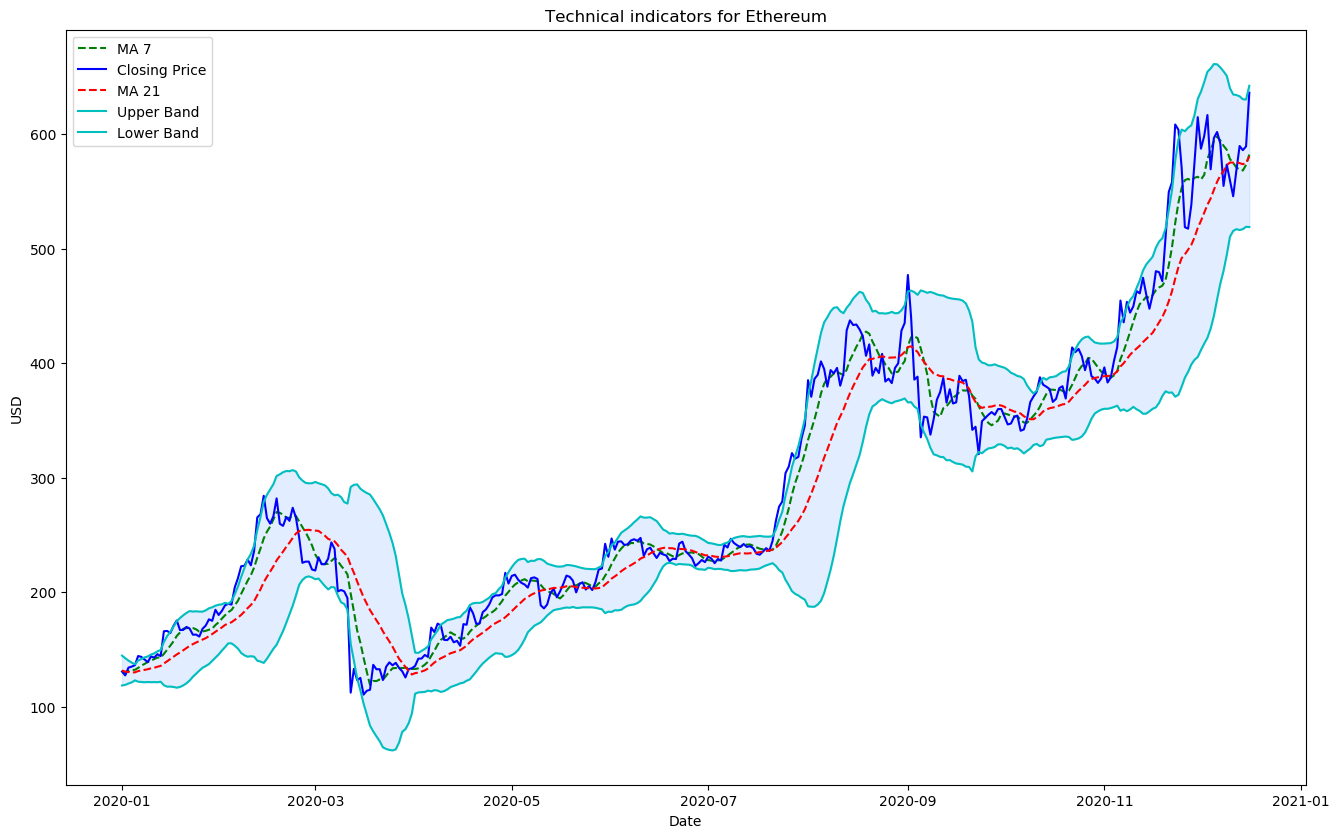

In [11]:
plot_technical_indicators(eth_data)

In [12]:
def correlation_heat_map(data):
    subset = data
    corrs = subset.corr(method='spearman')

    # Plot heatmap
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 5)
    
    sns.heatmap(corrs, 
                xticklabels=corrs.columns,
                yticklabels=corrs.columns,
                #annot=True,
                cmap="YlGnBu")
    
    corrs = pd.DataFrame(corrs)
    return corrs

def cut_features(data, correlations):
    data = data[correlations.loc[(correlations['price']) > 0.6].index]
    return data

,Open,High,Low,price,Volume,ma7,ma21,26ema,12ema,upper_band,lower_band,ema
Open,1.000000,0.995908,0.994227,0.989326,0.049401,0.988285,0.951094,0.951522,0.981233,0.914048,0.922989,0.994765
High,0.995908,1.000000,0.993301,0.994498,0.078036,0.985350,0.949722,0.949931,0.979349,0.915013,0.916265,0.997023
Low,0.994227,0.993301,1.000000,0.996456,0.019717,0.984385,0.944611,0.946433,0.976926,0.903381,0.922655,0.997785
price,0.989326,0.994498,0.996456,1.000000,0.042657,0.981560,0.943027,0.944194,0.974911,0.904320,0.916795,0.998535
Volume,0.049401,0.078036,0.019717,0.042657,1.000000,0.047462,0.052913,0.037342,0.058552,0.145899,-0.083947,0.044114
ma7,0.988285,0.985350,0.984385,0.981560,0.047462,1.000000,0.967832,0.967019,0.994204,0.931505,0.938571,0.987178
ma21,0.951094,0.949722,0.944611,0.943027,0.052913,0.967832,1.000000,0.994432,0.984412,0.961797,0.959221,0.947760
26ema,0.951522,0.949931,0.946433,0.944194,0.037342,0.967019,0.994432,1.000000,0.982845,0.955163,0.960057,0.948694
12ema,0.981233,0.979349,0.976926,0.974911,0.058552,0.994204,0.984412,0.982845,1.000000,0.947955,0.949013,0.979891
upper_band,0.914048,0.915013,0.903381,0.904320,0.145899,0.931505,0.961797,0.955163,0.947955,1.000000,0.863542,0.909168


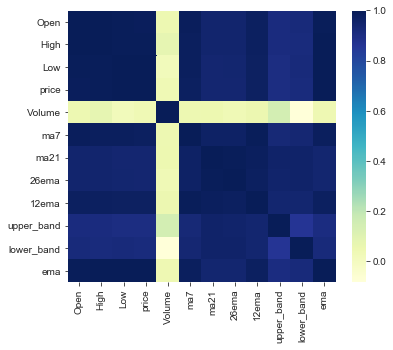

In [13]:
correlation_heat_map(eth_data)

(273, 7, 12) (64, 7, 12) (273,) (64,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(273, 7, 12) (64, 7, 12) (273,) (64,)


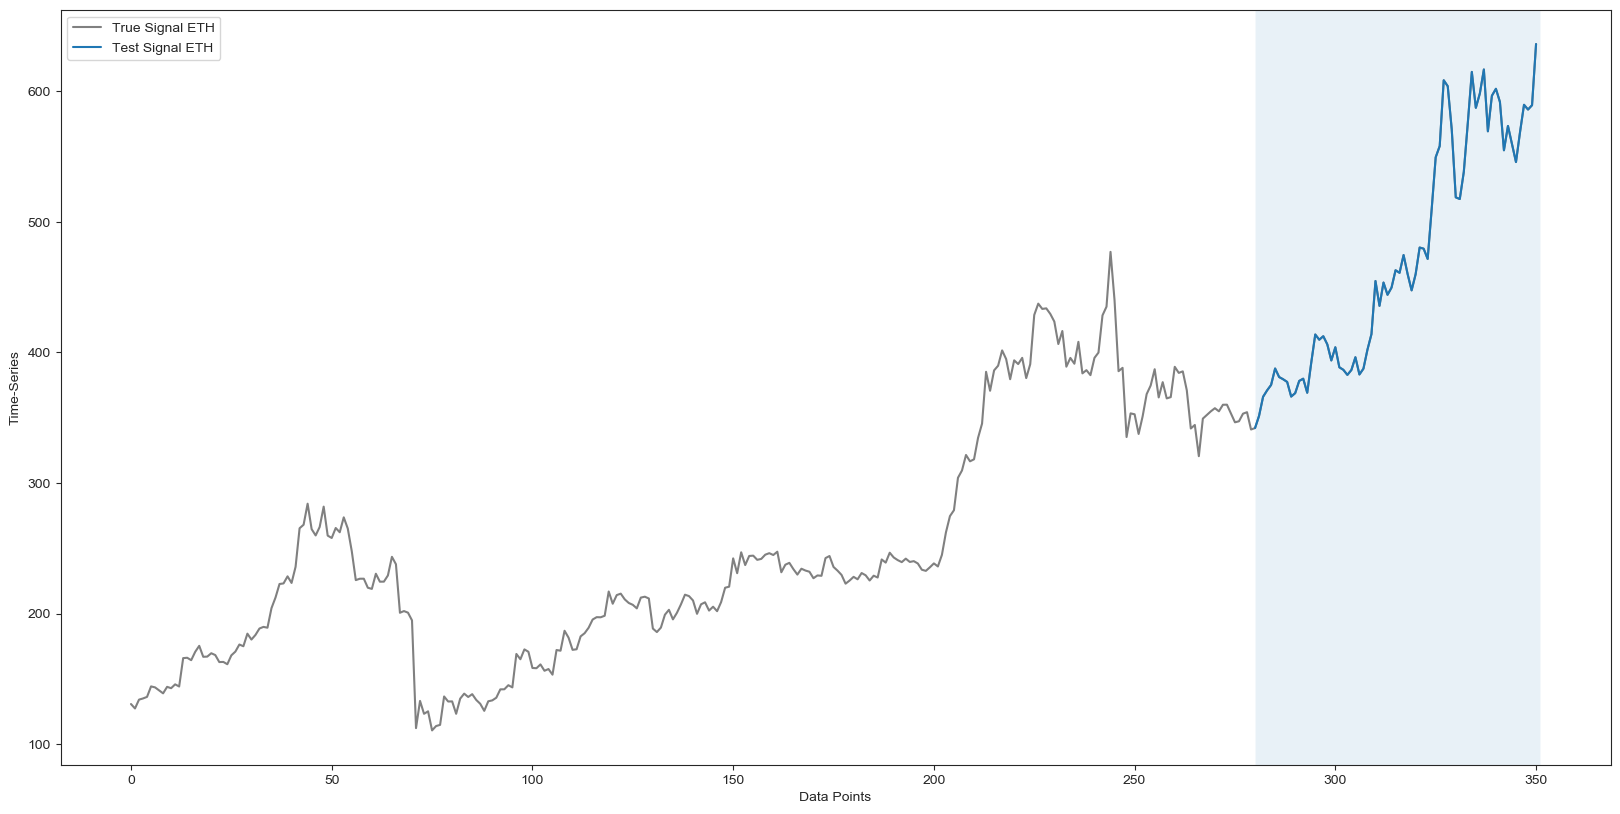

In [34]:
# Univariate technical model (False) or multivariate technical model (True)? 
status = False

# Create unscaled sets (useful for plotting results later)
train_set_raw, test_set_raw = split_data(eth_data) 
X_train_raw = create_inputs(train_set_raw, status)
y_train_raw = create_outputs(train_set_raw, status)
X_test_raw = create_inputs(test_set_raw, status)
y_test_raw = create_outputs(test_set_raw, status)
print(np.shape(X_train_raw), np.shape(X_test_raw), np.shape(y_train_raw), np.shape(y_test_raw))

normalized_data = normalize(eth_data)
train_set, test_set = split_data(normalized_data)
X_train = create_inputs(train_set, status)
y_train = create_outputs(train_set, status)
X_test = create_inputs(test_set, status)
y_test = create_outputs(test_set, status)

print(type(X_train), type(X_test), type(y_train), type(y_test))
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

show_train_test(eth_data, training_size)

In [35]:
# Initializing the model and training it for predicting ETH price for next day:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
model = build_model(X_train, output_size=1, neurons=neurons)
model.save('/Users/rebeccamqamelo/Desktop/CS156/Final Project/univariate_model')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 512)            1075200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [36]:
# Prevents overfitting
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, min_delta=10e-6)
#mc = tensorflow.keras.callbacks.ModelCheckpoint('best_model_LSTM_example.h5', monitor='val_loss', verbose=1, save_best_only=True)
checkpoint_filepath = '/Users/rebeccamqamelo/Desktop/CS156/Final Project/checkpoint'

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), callbacks=[es], verbose=1, shuffle=False)

np.save('/Users/rebeccamqamelo/Desktop/CS156/Final Project/univariate_history.npy', history.history)

Train on 273 samples, validate on 64 samples
Epoch 1/53
273/273 [==============================] - ETA: 12s - loss: 0.0295 - mae: 0.15 - ETA: 0s - loss: 0.0266 - mae: 0.1383 - 14s 51ms/sample - loss: 0.0321 - mae: 0.1507 - val_loss: 0.0146 - val_mae: 0.0953
Epoch 2/53
273/273 [==============================] - ETA: 0s - loss: 0.0188 - mae: 0.119 - ETA: 0s - loss: 0.0278 - mae: 0.142 - 2s 6ms/sample - loss: 0.0294 - mae: 0.1478 - val_loss: 0.1178 - val_mae: 0.3257
Epoch 3/53
273/273 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.045 - ETA: 0s - loss: 0.0076 - mae: 0.061 - 2s 6ms/sample - loss: 0.0072 - mae: 0.0590 - val_loss: 0.0138 - val_mae: 0.0927
Epoch 4/53
273/273 [==============================] - ETA: 0s - loss: 0.0124 - mae: 0.094 - ETA: 0s - loss: 0.0112 - mae: 0.091 - 2s 6ms/sample - loss: 0.0111 - mae: 0.0914 - val_loss: 0.0354 - val_mae: 0.1607
Epoch 5/53
273/273 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.048 - ETA: 0s - loss: 0.00

In [17]:
#history = np.load('/Users/rebeccamqamelo/Desktop/CS156/Final Project/univariate_history.npy', allow_pickle='TRUE').item()
#model = tensorflow.keras.models.load_model('/Users/rebeccamqamelo/Desktop/CS156/Final Project/univariate_model')

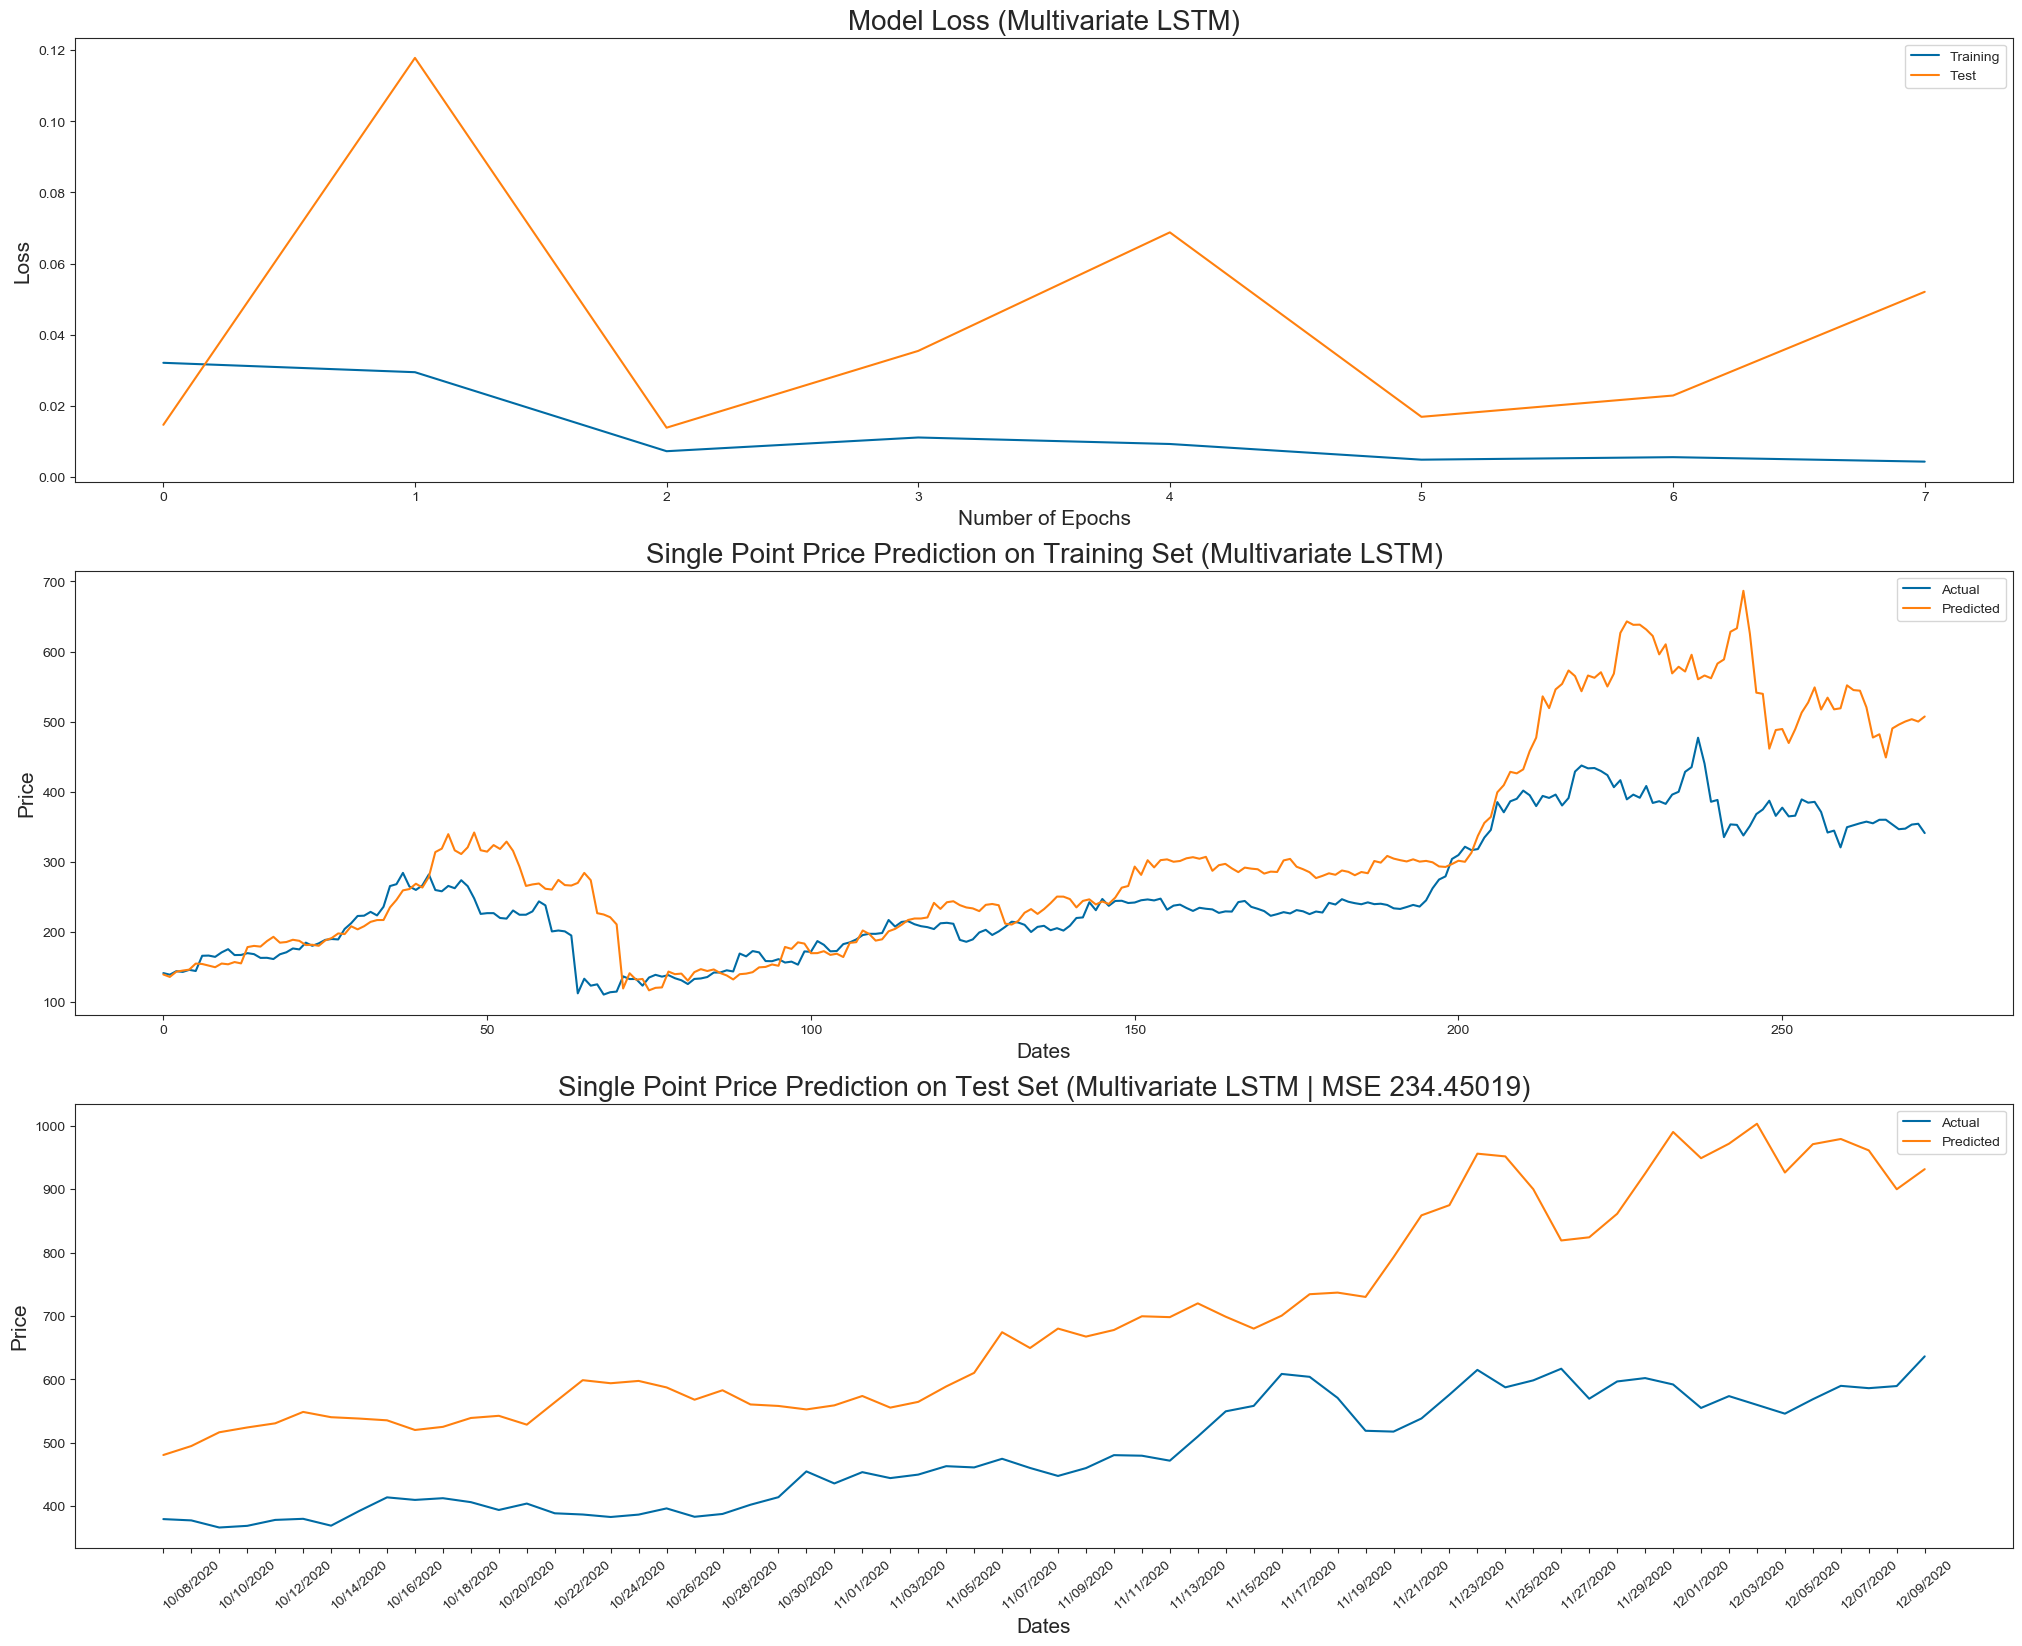

In [37]:
plot_results(eth_data, history, model, multidimensional=False)

In [38]:
# Evaluate the model on the test data using `evaluate`
print("Evaluating test data...")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test accuracy:", results)

Evaluating test data...
64/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Multivariate LSTM

### 1. Parsing the data from etherscan

In [20]:
# Skeleton code (without cloudflare bypass) from https://www.kaggle.com/sudalairajkumar/cryptocurrency-data-pull

urls = [
'https://etherscan.io/chart/etherprice',        # ETH-USD price
'https://etherscan.io/chart/tx',                # number of daily transactions
'https://etherscan.io/chart/address',           # number of unique addresses
'https://etherscan.io/chart/marketcap',         # total market capitalization
'https://etherscan.io/chart/hashrate',          # daily hashrate (measure of the processing power of the Ethereum network)
'https://etherscan.io/chart/difficulty',        # mining difficulty (number of hashes required to find a valid solution to solve the next Ethereum block and earn mining rewards)
'https://etherscan.io/chart/blocks',            # number of blocks produced per day
'https://etherscan.io/chart/uncles',            # number of uncle blocks produced daily (when two blocks are mined and submitted to the ledger at roughly the same time, but only one can enter)
'https://etherscan.io/chart/blocksize',         # average blocksize in bytes on the Ethereum blockchain
'https://etherscan.io/chart/blocktime',         # average time taken in seconds for a block to be included in the Ethereum blockchain
'https://etherscan.io/chart/gasprice',          # average cost of a transaction in gwei
'https://etherscan.io/chart/gaslimit',          # average maximum price users are willing to pay when performing a transaction
'https://etherscan.io/chart/gasused',           # average gas used per day
#'https://etherscan.io/chart/ethersupply',      # total supply of ether on the Ethereum network
'https://etherscan.io/chart/tokenerc-20txns',   # number of ERC20 tokens transferred daily   
]

suffix_to_add = '?output=csv' # downloads the .csv data

def get_ether_data():
    """
    This function uses urllib3 to bypass etherscan's Cloudflare restriction 
    and returns a merged pandas DataFrame containing all the timeseries data in the url provided.
    """
    
    counter = 0
    for url in urls:
        header = ['Date', 'TimeStamp', "eth_" + url.split("/")[-1].replace("-","_")]
        print('Parsing', header[-1], '...')
        
        req = urllib3.PoolManager(
            cert_reqs='CERT_REQUIRED',
            ca_certs=certifi.where()
        )
        
        res = req.request('GET', url + suffix_to_add)
        soup = BeautifulSoup(res.data, 'html.parser')

        with open('/Users/rebeccamqamelo/Desktop/CS156/Final Project/bs4_'+header[-1]+'.txt', 'w', encoding='utf-8') as f_out:
            f_out.write(soup.prettify())

        temp_df = pd.read_csv(r'/Users/rebeccamqamelo/Desktop/CS156/Final Project/bs4_'+header[-1]+'.txt', header=0)
        
        #read_file.columns = ['Date', 'UnixTimeStamp', column]
        temp_df.to_csv(r'/Users/rebeccamqamelo/Desktop/CS156/Final Project/bs4_'+header[-1]+'.txt', index=None)

        col_names = temp_df.columns.tolist()
        if col_names[-1] == "Value" or col_names[-1] == "Value (Wei)" or col_names[-1] == "No. of ERC20 Token Transfers":
            col_names = col_names[:2] + [header[-1]]
            temp_df.columns = col_names
        else:
            temp_df = temp_df[["Date(UTC)","UnixTimeStamp", "Supply", "MarketCap"]]
            temp_df.columns = ["Date(UTC)","UnixTimeStamp", "eth_supply", "eth_marketcap"]
            
        if counter == 0:
            df = temp_df.copy()
        else:
            df = pd.merge(df, temp_df, on=["Date(UTC)", "UnixTimeStamp"], how="left")
            
        print(temp_df.shape, df.shape)
        counter += 1
        time.sleep(1) 
        
    df.to_csv("/Users/rebeccamqamelo/Desktop/CS156/Final Project/etherscan_data.csv", index=False)

In [21]:
get_ether_data()

Parsing eth_etherprice ...
(1969, 3) (1969, 3)
Parsing eth_tx ...
(1969, 3) (1969, 4)
Parsing eth_address ...
(1969, 3) (1969, 5)
Parsing eth_marketcap ...
(1969, 4) (1969, 7)
Parsing eth_hashrate ...
(1969, 3) (1969, 8)
Parsing eth_difficulty ...
(1969, 3) (1969, 9)
Parsing eth_blocks ...
(1969, 3) (1969, 10)
Parsing eth_uncles ...
(1969, 3) (1969, 11)
Parsing eth_blocksize ...
(1969, 3) (1969, 12)
Parsing eth_blocktime ...
(1969, 3) (1969, 13)
Parsing eth_gasprice ...
(1969, 3) (1969, 14)
Parsing eth_gaslimit ...
(1969, 3) (1969, 15)
Parsing eth_gasused ...
(1969, 3) (1969, 16)
Parsing eth_tokenerc_20txns ...
(1967, 3) (1969, 17)


In [22]:
data = pd.read_csv('/Users/rebeccamqamelo/Desktop/CS156/Final Project/etherscan_data.csv')
data.drop('UnixTimeStamp', axis=1, inplace=True)
data.drop('eth_uncles', axis=1, inplace=True)
data.drop('eth_blocks', axis=1, inplace=True)
data.drop('eth_blocktime', axis=1, inplace=True)
data.drop('eth_tokenerc_20txns', axis=1, inplace=True) # ⚠️ Fix later, currently returning nans...
data['Date(UTC)'] = pd.to_datetime(data['Date(UTC)'])
data.rename(columns={'Date(UTC)': 'Date'}, inplace=True)
data.rename(columns={'eth_etherprice': 'price'}, inplace=True)

# Isolate 2020 data
data = data[(data['Date'] > '2019-12-31') & (data['Date'] < '2020-12-17')]
data.set_index('Date', inplace=True)
print('N. rows:', len(data))

data.head()

N. rows: 351


,price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocksize,eth_gasprice,eth_gaslimit,eth_gasused
Date,,,,,,,,,,,
2020-01-01,130.60,466526,84127955,1.091043e+08,14249.024694,147405.0591,2455.804,20546,11664054350,9950157,37203395960
2020-01-02,127.18,505639,84187457,1.091162e+08,13877.395713,153540.7797,2222.098,20138,10566318855,9882420,37302668848
2020-01-03,134.25,581641,84264751,1.091298e+08,14650.680110,157936.4610,1983.100,19394,11494907509,9890691,41968777422
2020-01-04,134.33,559074,84336889,1.091436e+08,14661.254108,166126.2541,2077.179,19029,9665112896,9836172,38380154394
2020-01-05,135.44,524664,84402226,1.091571e+08,14784.235419,160833.3584,2041.128,18408,9764148415,9850572,37927743195


In [23]:
print(len(data.columns))
print(data.columns)

11
Index(['price', 'eth_tx', 'eth_address', 'eth_supply', 'eth_marketcap',
       'eth_hashrate', 'eth_difficulty', 'eth_blocksize', 'eth_gasprice',
       'eth_gaslimit', 'eth_gasused'],
      dtype='object')


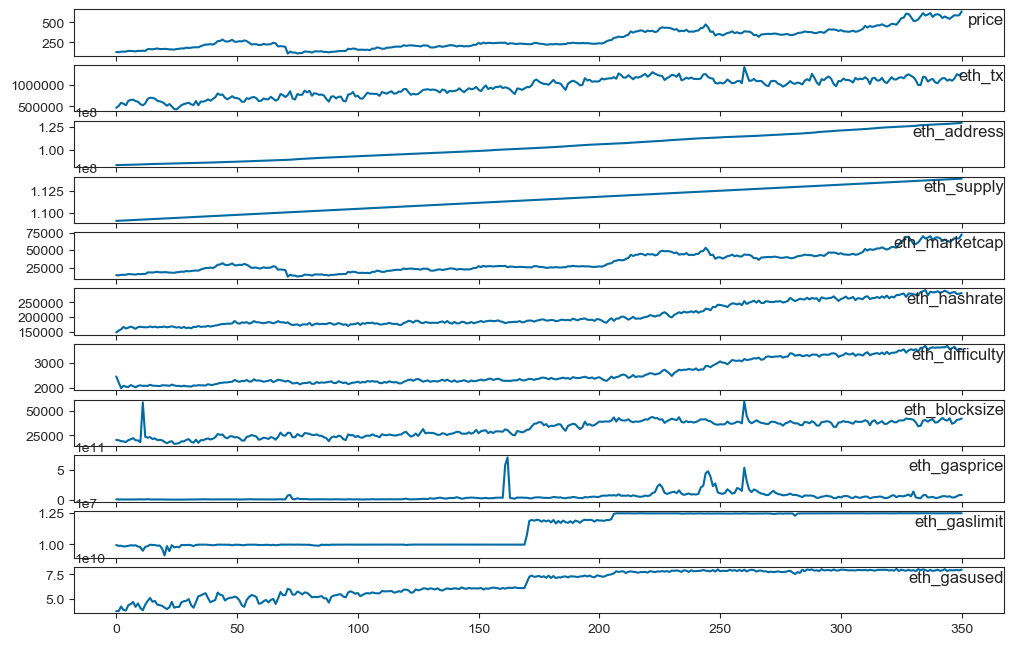

In [24]:
from pandas import read_csv
from matplotlib import pyplot
values = data.values
# specify columns to plot
groups = [i for i in range(11)]
i = 1
# plot each column
pyplot.figure()
rcParams['figure.figsize'] = 30,40
for group in groups:

    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
    
pyplot.show()

In [25]:
rcParams['figure.figsize'] = 10,8

In [26]:
def histogram_intersection(a, b):
    #coef = np.minimum(a, b).sum().round(decimals=1)
    coef, p = spearmanr(a, b)
    return coef, p

def correlation_heat_map(data):
    #subset = data.drop(['Date'], axis=1)
    subset = data
    corrs = subset.corr(method='spearman')
    
    # Plot heatmap
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 5)
    
    sns.heatmap(corrs, 
                xticklabels=corrs.columns,
                yticklabels=corrs.columns)
    
    #coef, p = [histogram_intersection(a, b) for ]
    #corrs = subset.corr(method=histogram_intersection)

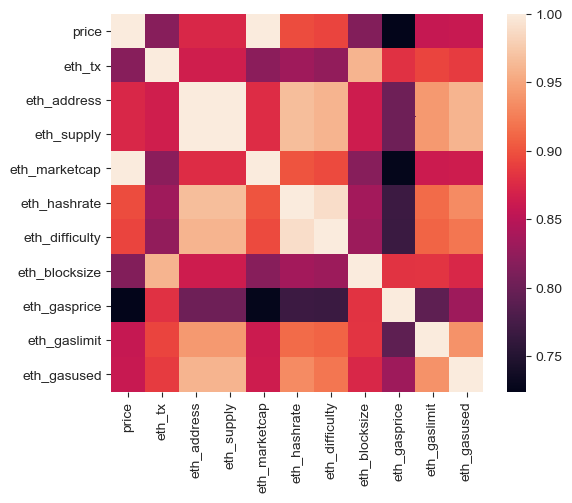

In [27]:
correlation_heat_map(data)

### Splitting into training and test data

In [28]:
# Create unscaled sets (useful for plotting results later)
train_set_raw, test_set_raw = split_data(data)
X_train_raw = create_inputs(train_set_raw, True)
y_train_raw = create_outputs(train_set_raw, True)
X_test_raw = create_inputs(test_set_raw, True)
y_test_raw = create_outputs(test_set_raw, True)
print(np.shape(X_train_raw), np.shape(X_test_raw), np.shape(y_train_raw), np.shape(y_test_raw))

# Normalize the data
normalized_data = normalize(data)
# Split the normalized data into a training and test set:
train_set, test_set = split_data(normalized_data)
X_train = create_inputs(train_set, True)
y_train = create_outputs(train_set, True)
X_test = create_inputs(test_set, True)
y_test = create_outputs(test_set, True)

print(type(X_train), type(X_test), type(y_train), type(y_test))
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(273, 7, 11) (64, 7, 11) (273,) (64,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(273, 7, 11) (64, 7, 11) (273,) (64,)


In [29]:
# Initializing the model and training it for predicting ETH price for next day:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
model = build_model(X_train, output_size=1, neurons=neurons)
model.save('/Users/rebeccamqamelo/Desktop/CS156/Final Project/multivariate_model')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 512)            1073152   
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [30]:
# Prevents overfitting
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, min_delta=10e-6)
#mc = tensorflow.keras.callbacks.ModelCheckpoint('best_model_LSTM_example.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), callbacks=[es], verbose=1, shuffle=False)

np.save('/Users/rebeccamqamelo/Desktop/CS156/Final Project/multivariate_history.npy', history.history)

Train on 273 samples, validate on 64 samples
Epoch 1/53
273/273 [==============================] - ETA: 11s - loss: 0.0287 - mae: 0.14 - ETA: 0s - loss: 0.0184 - mae: 0.1115 - 13s 47ms/sample - loss: 0.0183 - mae: 0.1124 - val_loss: 0.3559 - val_mae: 0.5775
Epoch 2/53
273/273 [==============================] - ETA: 0s - loss: 0.0142 - mae: 0.098 - ETA: 0s - loss: 0.0881 - mae: 0.234 - 2s 6ms/sample - loss: 0.0886 - mae: 0.2389 - val_loss: 0.1147 - val_mae: 0.3075
Epoch 3/53
273/273 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.064 - ETA: 0s - loss: 0.0093 - mae: 0.079 - 2s 6ms/sample - loss: 0.0094 - mae: 0.0810 - val_loss: 0.0543 - val_mae: 0.1865
Epoch 4/53
273/273 [==============================] - ETA: 0s - loss: 0.0127 - mae: 0.095 - ETA: 0s - loss: 0.0143 - mae: 0.095 - 2s 6ms/sample - loss: 0.0149 - mae: 0.0992 - val_loss: 0.0828 - val_mae: 0.2511
Epoch 5/53
273/273 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.075 - ETA: 0s - loss: 0.00

In [31]:
#history = np.load('/Users/rebeccamqamelo/Desktop/CS156/Final Project/multivariate_history.npy', allow_pickle='TRUE').item()
#model = tensorflow.keras.models.load_model('/Users/rebeccamqamelo/Desktop/CS156/Final Project/multivariate_model')

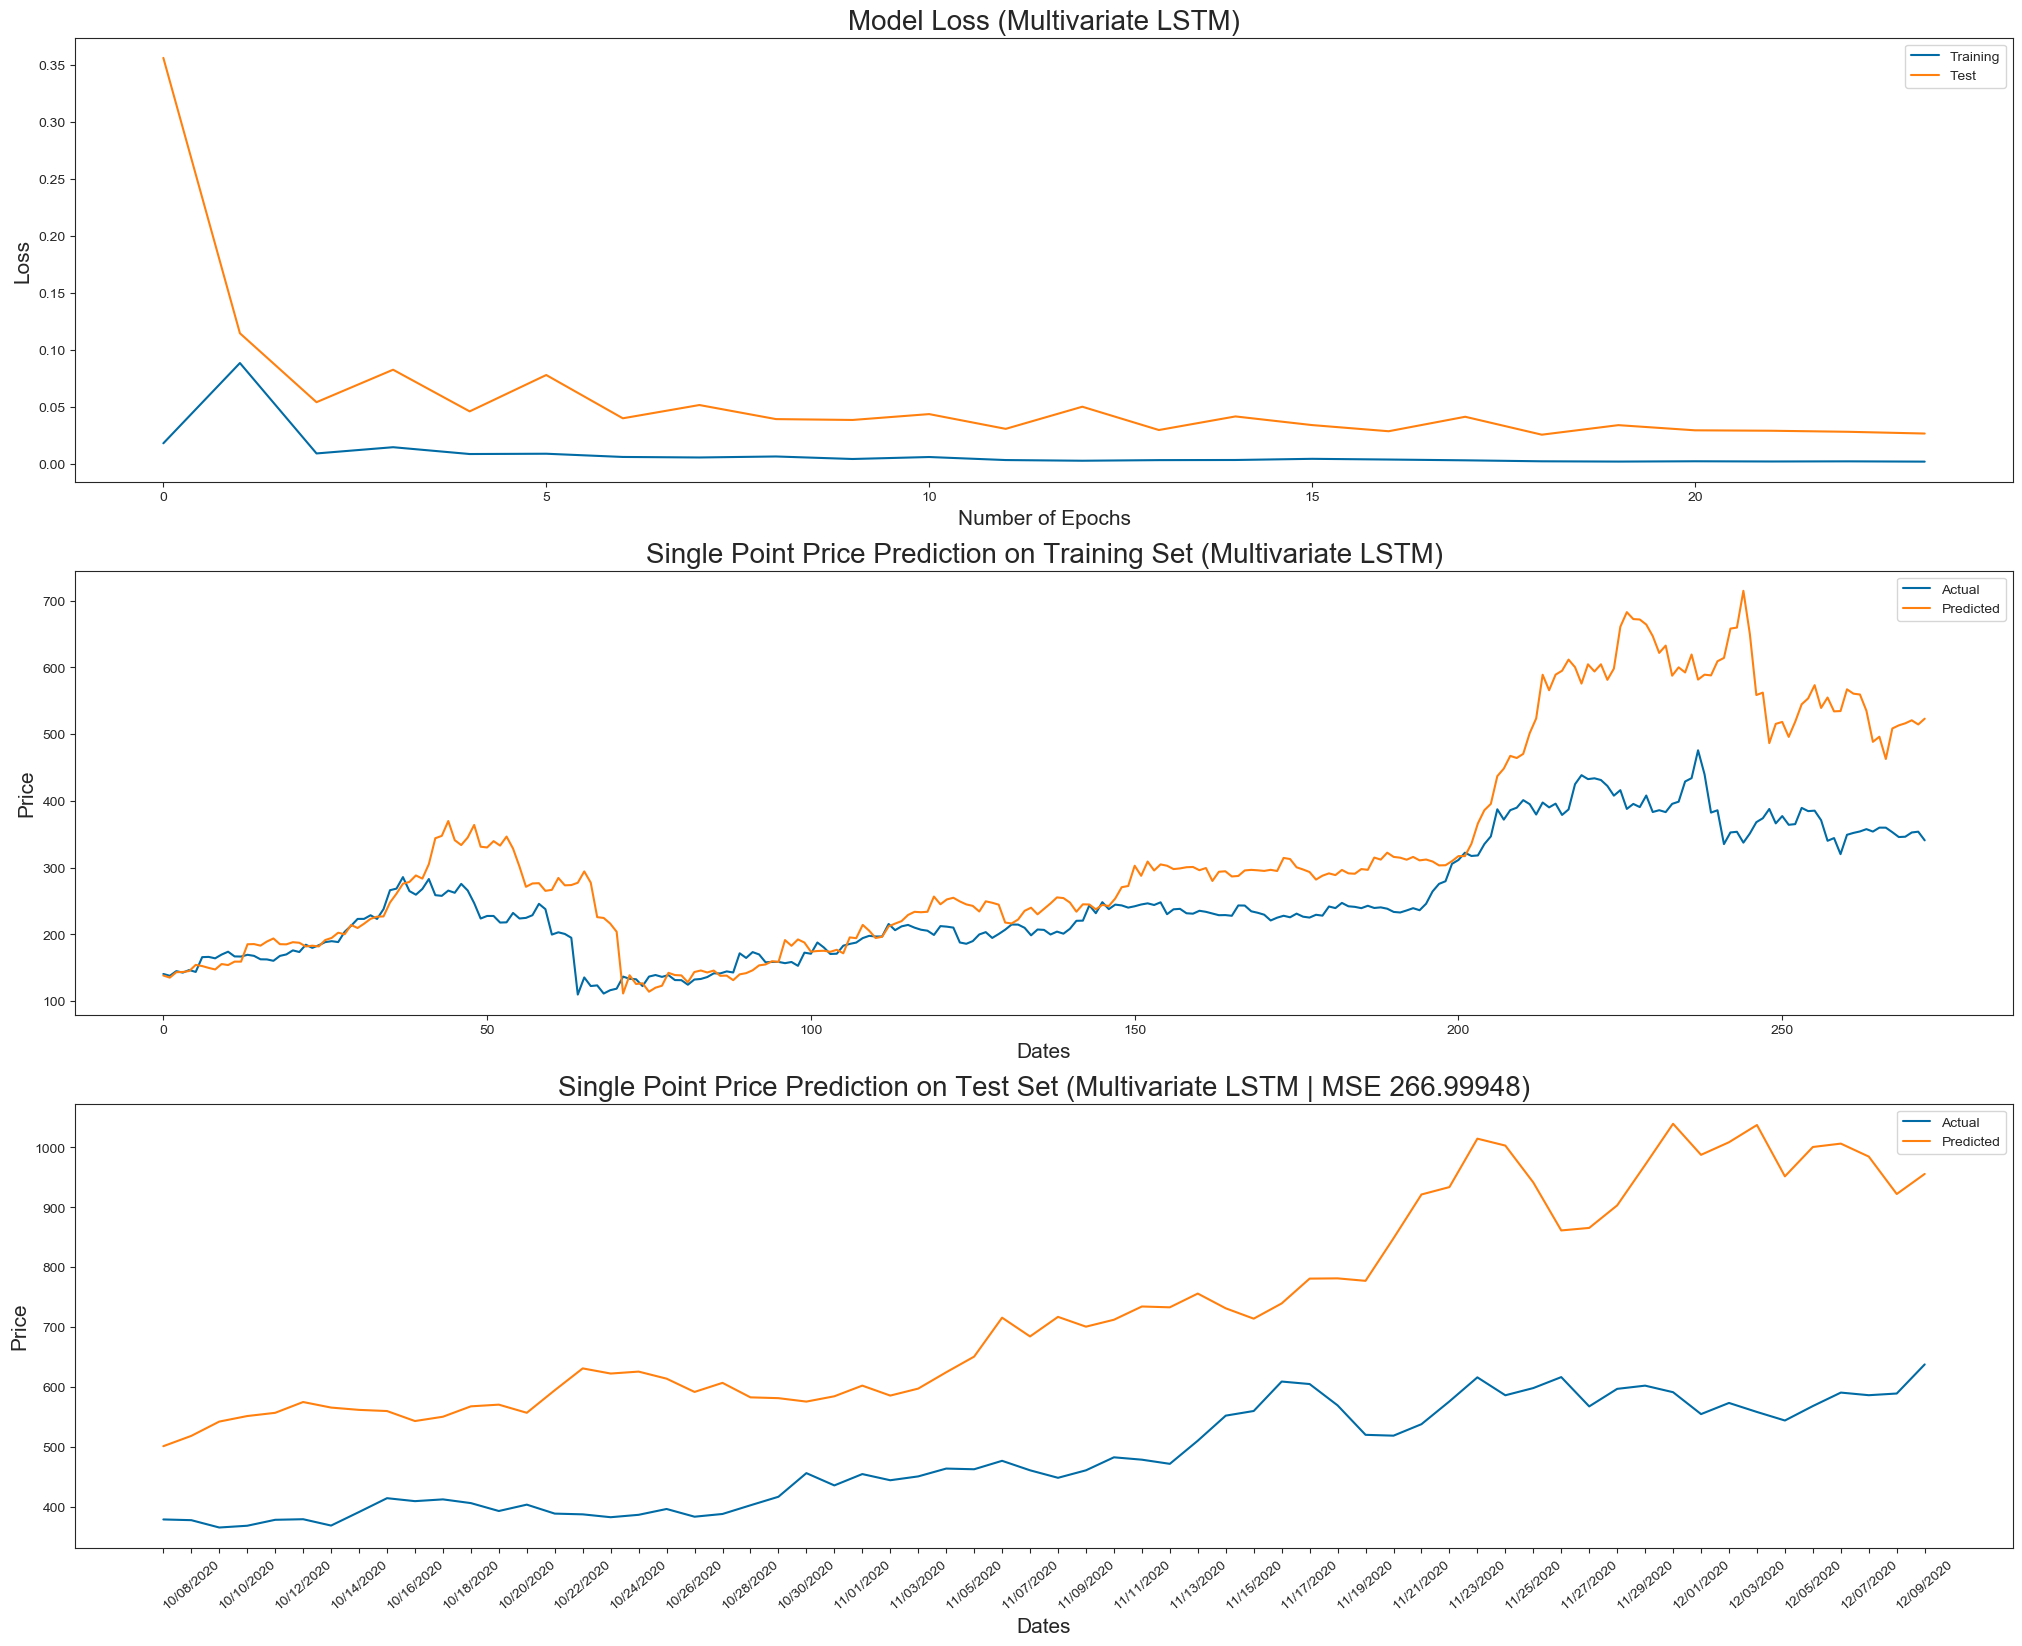

In [32]:
plot_results(data, history, model, True)

In [33]:
# Evaluate the model on the test data using `evaluate`
print("Evaluating test data...")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test accuracy:", results)

Evaluating test data...
64/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================